<a href="https://colab.research.google.com/github/noora20FH/heart_disease_classification/blob/main/heart_disease_classification_spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease 

#Heart Disease Prediction - A Classification Problem using PySpark
##Objective:
The main objective of this small project was to implement a machine learning pipeline using PySpark after taking the udemy course Spark and Python for Big Data using Pyspark
All of the methods used may be done fairly efficiently without the need of Spark by utilizing packages such as Scikit-learn.
##Topics and Methods Covered:

*   Pyspark
*   Data Visualization
*   Exploratory Data Analysis
*   Sampling for Unbalanced Datasets


*   Classification Algorithms:
  * Logistic Regression
  *   Random Forest Classifier
  *   Naive Bayes
*   Evaluation of classification models

##Objective of the Analysis:
Develop a model capable of detecting people who may have undetected heart disease based on other health related metrics.

In [1]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=c2bfd53d721c60a6a3047f8d3aabb898998e4d8771bdf5e9aeb7894ef67df598
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [2]:
from google.colab import drive


#Access my google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np

In [4]:
#imports and setup
from pyspark.sql import SparkSession
from pyspark.ml.feature import (VectorAssembler, OneHotEncoder, StringIndexer)
from pyspark.ml import Pipeline
from pyspark.ml.classification import (LogisticRegression, RandomForestClassifier, NaiveBayes)
from pyspark.sql.functions import (col, explode, array, lit)
from pyspark.ml.evaluation import (BinaryClassificationEvaluator, MulticlassClassificationEvaluator)
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType
import pyspark.sql.functions as F
 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
 
spark = SparkSession.builder.appName('HeartDiseaseClassification').getOrCreate()



#Reading Data
Data originates from a CDC telephone survey on American Citizens. There's a significant volume of data - around 400k individuals.

In [25]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('HeartDiseaseClassification').getOrCreate()

heartdf = spark.read.csv('/content/drive/MyDrive/TUGAS_NOORA/heart_2020_cleaned.csv', inferSchema=True, header=True)

print("Original Dataset (Rows:Columns): ")
print((heartdf.count(), len(heartdf.columns)))

heartdf.show(5)  # Display first 5 rows of the DataFrame

Original Dataset (Rows:Columns): 
(319795, 18)
+------------+-----+-------+---------------+------+--------------+------------+-----------+------+-----------+-----+--------+----------------+---------+---------+------+-------------+----------+
|HeartDisease|  BMI|Smoking|AlcoholDrinking|Stroke|PhysicalHealth|MentalHealth|DiffWalking|   Sex|AgeCategory| Race|Diabetic|PhysicalActivity|GenHealth|SleepTime|Asthma|KidneyDisease|SkinCancer|
+------------+-----+-------+---------------+------+--------------+------------+-----------+------+-----------+-----+--------+----------------+---------+---------+------+-------------+----------+
|          No| 16.6|    Yes|             No|    No|           3.0|        30.0|         No|Female|      55-59|White|     Yes|             Yes|Very good|      5.0|   Yes|           No|       Yes|
|          No|20.34|     No|             No|   Yes|           0.0|         0.0|         No|Female|80 or older|White|      No|             Yes|Very good|      7.0|    No|    

##Data Labels
The table, as seen above, contains only four numerical columns. Columns are classified into three categories:

label: the label of the data ('HeartDisease') used for classification;
numerical_cols: the names of the 4 numerical columns;
categorical_cols: the remanining nominal columns.

In [23]:
label = 'HeartDisease'
numerical_cols = ['BMI', 'PhysicalHealth','MentalHealth','SleepTime']
categorical_cols = list(set(heartdf.columns) - set(numerical_cols) -set([label]))

#Data Distribution

In [26]:
# stats of numerical variables
heartdf.select(numerical_cols).describe().show()

+-------+------------------+------------------+-----------------+------------------+
|summary|               BMI|    PhysicalHealth|     MentalHealth|         SleepTime|
+-------+------------------+------------------+-----------------+------------------+
|  count|            319795|            319795|           319795|            319795|
|   mean|28.325398520925706|3.3717100017198516|3.898366140808956| 7.097074688472302|
| stddev| 6.356100200470763| 7.950850182571355|7.955235218943604|1.4360070609642803|
|    min|             12.02|               0.0|              0.0|               1.0|
|    max|             94.85|              30.0|             30.0|              24.0|
+-------+------------------+------------------+-----------------+------------------+



<Axes: title={'center': 'Number of Observations per label'}, xlabel='HeartDisease'>

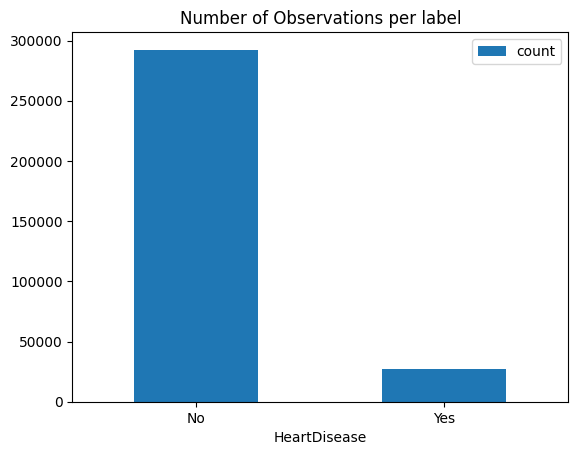

In [27]:
# check number of observations of differente samples
heartdf.groupBy(label).count().toPandas().plot.bar(x='HeartDisease', rot=0, title='Number of Observations per label')

#Preparing Data for Classification Models

##Working with an Unbalanced Dataset. Oversampling Smallest Class
As can be seen above, this dataset is extremely imbalanced. This is frequent in disease-related datasets.

In this section, I will perform oversampling on the smaller class to lessen the bias of the classification models.

In [29]:

#splitting data into train and test sets before Oversampling
train_df, test_df = heartdf.randomSplit([.7,.3])

<Axes: title={'center': 'Number of Observations in Train subset after Oversampling'}, xlabel='HeartDisease'>

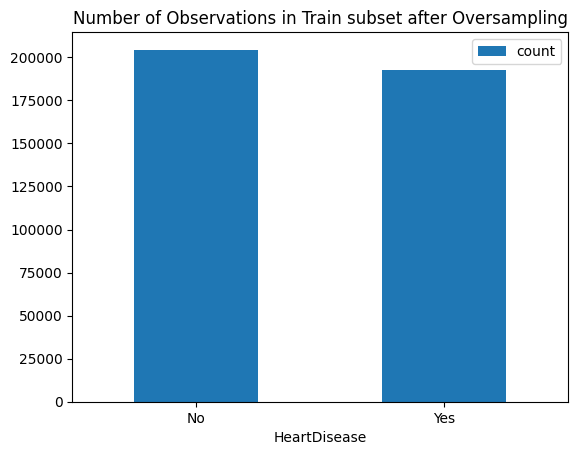

In [30]:
#spliting df by classes
major_df = train_df.filter(col(label) == 'No')
minor_df = train_df.filter(col(label) == 'Yes')
#ratio of number observation major vs minor class
r = int(major_df.count()/minor_df.count())
 
# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in range(r)]))).drop('dummy')
 
# combine both oversampled minority rows and previous majority rows 
combined_train_df = major_df.unionAll(oversampled_df)
                                                           
combined_train_df.groupBy(label).count().toPandas().plot.bar(x='HeartDisease', rot=0, title='Number of Observations in Train subset after Oversampling')

##Processing Categorical Columns for Spark Pipeline
String columns cannot be used as input to Spark. To address this, I'll need to employ an indexer on these columns, followed by an encoding.

I also need to vectorize all the features into a features column after I have all columns with numerical values.

In [31]:
# Indexers for categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=col+'_indexed') for col in categorical_cols]
# Encoders for categorical columns
encoders = [OneHotEncoder(inputCol=col+'_indexed', outputCol=col+'_encoded') for col in categorical_cols]
 
# Indexer for classification label:
label_indexer = StringIndexer(inputCol=label, outputCol=label+'_indexed')

In [33]:
#assemble all features as vector to be used as input for Spark MLLib
assembler = VectorAssembler(inputCols= [col+'_encoded' for col in categorical_cols] + numerical_cols, outputCol='features')
# Creating data processing pipeline
pipeline = Pipeline(stages= indexers + encoders + [label_indexer, assembler])


#Applying Classification Models
Models Implemented:

* lr - Logistic Regression

* rfc - Random Forest Classifier

* nb - Naive Bayes

In [34]:
lr = LogisticRegression(featuresCol='features', labelCol=label+'_indexed')
rfc = RandomForestClassifier(featuresCol='features', labelCol=label+'_indexed', numTrees=100)
nb = NaiveBayes(featuresCol='features', labelCol=label+'_indexed')

In [35]:
# creating pipelines with machine learning models
pipeline_lr = Pipeline(stages=[pipeline, lr])
pipeline_rfc = Pipeline(stages=[pipeline, rfc])
pipeline_nb = Pipeline(stages=[pipeline, nb])

In [36]:
#fitting models with train subset
lr_fit = pipeline_lr.fit(combined_train_df)
rfc_fit = pipeline_rfc.fit(combined_train_df)
nb_fit = pipeline_nb.fit(combined_train_df)

In [ ]:

# predictions for test subset
pred_lr = lr_fit.transform(test_df)
pred_rfc = rfc_fit.transform(test_df)
pred_nb = nb_fit.transform(test_df)

##Evaluating Results

###Area Under Curve - AUC
The AUC of a random selection of labels is 0.5. The closer this metric is to one, the better the model predicts the data labels.

Regarding this metric, the logistic regression model outperforms the Random Forest Classifier. The Naive Bayes Classifier performed the poorest.

In [37]:
pred_AUC = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol=label+'_indexed')

In [ ]:
AUC_lr = pred_AUC.evaluate(pred_lr)
AUC_rfc = pred_AUC.evaluate(pred_rfc)
AUC_nb = pred_AUC.evaluate(pred_nb)
print(AUC_lr, AUC_rfc, AUC_nb)

###Accuracy - A poor Evaluation Metric for Unbalanced Classification
Accuracy is a common metric used when evaluating classification problems. It is calculated by

(TP + TN) / All Samples

​
 
Where TP = True Positives and TN = True Negatives

Note that for this particular case this is not the best metric because the Negative label represents the grand majority of the observation.

As an extreme example, if I predicted that all observations would be negative for heart disease, the accuracy for this test subgroup would be 91.48 percent.

Looking at the results for these three models, the Naive Bayes has the best accuracy while being the lowest performing model in terms of TP. When analyzing these models, special emphasis should be placed on the TP cases.

In [ ]:
# calculating accuracy for all negative prediction mentioned above
acc_all_negative = test_df.filter(test_df[label]=='No').count() / test_df.count()
acc_all_negative

In [ ]:
acc_evaluator = MulticlassClassificationEvaluator(labelCol=label+'_indexed', predictionCol="prediction", metricName="accuracy")

In [ ]:
acc_lr = acc_evaluator.evaluate(pred_lr)
acc_rfc = acc_evaluator.evaluate(pred_rfc)
acc_nb = acc_evaluator.evaluate(pred_nb)
 
print('Logistic Regression accuracy: ', '{:.2f}'.format(acc_lr*100), '%', sep='')
print('Random Forest accuracy: ', '{:.2f}'.format(acc_rfc*100), '%', sep='')
print('Naive Bayes accuracy: ', '{:.2f}'.format(acc_nb*100), '%', sep='')

###Confusion Matrices

In [ ]:
def confusion_matrix(pred_df):
    preds_labels = pred_df.select(['prediction',label+'_indexed']).withColumn(label+'_indexed', F.col(label+'_indexed').cast(FloatType())).orderBy('prediction')
    preds_labels = preds_and_labels.select(['prediction',label+'_indexed'])
    metrics = MulticlassMetrics(preds_labels.rdd.map(tuple))
    return metrics.confusionMatrix().toArray()

In [ ]:
def confusion_matrix_plot(conf_mat, ax, title = 'Confusion Matrix'):
    names = ['True Negative','False Positive','False Negative','True Positive']
 
    number = ["{0:0.0f}".format(value) for value in conf_mat.flatten()]
 
    percent = ["{0:.2%}".format(value) for value in conf_mat.flatten()/np.sum(conf_mat)]
 
    labels = [f"{v1}\n\n{v2}\n\n{v3}" for v1, v2, v3 in zip(names, number, percent)]
 
    labels = np.asarray(labels).reshape(2,2)
 
    ax = sns.heatmap(conf_mat, annot=labels, fmt='', cmap='Blues', cbar=False, ax=ax)
 
    ax.set_title(title+'\n');
    ax.set_xlabel('\nPredicted Labels')
    ax.set_ylabel('Real Labels');
 
    ax.xaxis.set_ticklabels(['No','Yes'])
    ax.yaxis.set_ticklabels(['No','Yes'])
    
    return ax

In [ ]:
conf_lr = confusion_matrix(pred_lr)
conf_rfc = confusion_matrix(pred_rfc)
conf_nb = confusion_matrix(pred_nb)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))
 
ax1 = confusion_matrix_plot(conf_lr, ax1,'Logistic Regression - Confusion Matrix')
ax2 = confusion_matrix_plot(conf_rfc, ax2,'Random Forest Classifier - Confusion Matrix')
ax3 = confusion_matrix_plot(conf_nb, ax3, 'Naive Bayes - Confusion Matrix')
 
plt.show()

###Sensitivity Metric
Sensitivity is the True Positive Rate of the classification:

TP / (TP+FN)

 
where TP = True Positive and FN = False Negative.

It is a measure of how well the Positive label is predicted.

In [ ]:
def sensitivity(conf_mat):
    TP = conf_mat[1][1]
    FN = conf_mat[1][0]
    result = TP / (TP + FN)
    return result

In [ ]:

print('Logistic Regression sensitivity: ', (sensitivity(conf_lr)*100).round(2), '%', sep='')
print('Random Forest sensitivity: ', (sensitivity(conf_rfc)*100).round(2), '%', sep='')
print('Naive Bayes sensitivity: ', (sensitivity(conf_nb)*100).round(2), '%', sep='')

#Results
The best performing model was Logistic Regression;

The true positive rate was 77%. This indicates that 77 percent of heart disease patients were appropriately identified;

The model's False Positive rate (or Specificity) is high, although lowering this statistic is not the primary goal.

Overall, the Logistic Regression model yields useful results (sensitivity higher than 50% = better than random guess). Despite this, 77 percent is still a low percentage for classification algorithms.